In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
# Using plotly.express
import plotly.express as px

pd.set_option('display.max_rows',10000)
pd.set_option('display.max_columns',100)
pd.set_option('display.max_colwidth',100)
pd.set_option('display.width',None)

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.style.use('ggplot')

In [2]:
sales_data = pd.read_csv("data/sales_by_dept.csv")
sales_data.Date = pd.to_datetime(sales_data.Date)
# sales_data = sales_data.sort_values(by = "Date")
sales_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [27]:
sales_data['Store'].nunique() * sales_data['Dept'].nunique()

3645

In [26]:
sales_data['Dept'].nunique()

81

In [4]:
q = """
    Select A.Store, COUNT(DEPT) AS No_of_dept
    FROM
    (SELECT
        Store, DEPT
     FROM
        sales_data
     GROUP BY
        Store, Dept) A
    GROUP BY
        A.Store
    ORDER BY
        No_of_dept DESC
        """

store_no_of_dept = pysqldf(q)
store_no_of_dept.head()

,Store,No_of_dept
0,13,79
1,15,79
2,19,79
3,2,78
4,4,78


In [5]:
q = """SELECT
        Store, DEPT, COUNT(DEPT) as No_sold_per_dept
     FROM
        sales_data
     GROUP BY
        Store, Dept
    ORDER BY
        No_sold_per_dept DESC
        """

store_dept_no_of_sold_per_dept = pysqldf(q)
store_dept_no_of_sold_per_dept.head()

,Store,Dept,No_sold_per_dept
0,1,1,143
1,1,2,143
2,1,3,143
3,1,4,143
4,1,5,143


In [6]:
q = """SELECT
        Store, Dept, AVG(Weekly_Sales) as Avg_weekly_sales_per_dept
     FROM
        sales_data
     GROUP BY
        Store, Dept
    ORDER BY
        Avg_weekly_sales_per_dept DESC
        """

store_dept_avg_weekly_sale_per_dept = pysqldf(q)
store_dept_avg_weekly_sale_per_dept.head()

,Store,Dept,Avg_weekly_sales_per_dept
0,14,92,182527.956014
1,2,92,164840.230979
2,20,92,164633.741538
3,13,92,162034.099301
4,4,92,159365.107902


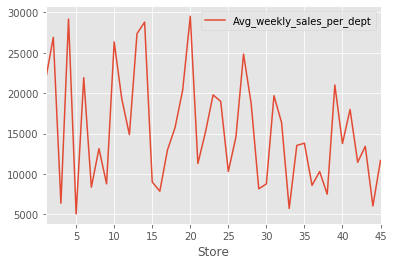

In [7]:
q = """SELECT
        Store, AVG(Weekly_Sales) as Avg_weekly_sales_per_dept
     FROM
        sales_data
     GROUP BY
        Store
    ORDER BY
        Store DESC
        """

store_avg_weekly_sale_per_dept = pysqldf(q)
store_avg_weekly_sale_per_dept.index = store_avg_weekly_sale_per_dept.Store
del store_avg_weekly_sale_per_dept['Store']
store_avg_weekly_sale_per_dept.plot()

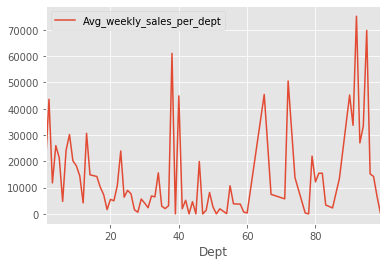

In [8]:
q = """SELECT
        DEPT, AVG(Weekly_Sales) as Avg_weekly_sales_per_dept
     FROM
        sales_data
     GROUP BY
        Dept
    ORDER BY
        Dept DESC
        """

dept_avg_weekly_sale_per_dept = pysqldf(q)
dept_avg_weekly_sale_per_dept.index = dept_avg_weekly_sale_per_dept.Dept
del dept_avg_weekly_sale_per_dept['Dept']
dept_avg_weekly_sale_per_dept.plot()

#### Taking store 1 first

In [10]:
sales_store1 = sales_data[sales_data['Store'] == 1]
sales_store1_dept1 = sales_store1[sales_store1['Dept'] == 1][['Date','Weekly_Sales']]
sales_store1_dept1.index = sales_store1_dept1['Date']
del sales_store1_dept1['Date']

/home/sagnik/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



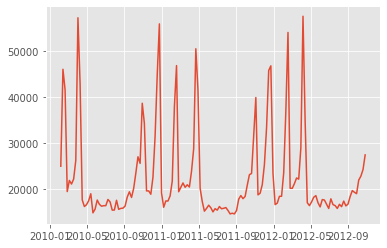

In [4]:
plt.plot(sales_store1_dept1.index, sales_store1_dept1['Weekly_Sales'])

### Checking the seasonality for graphs

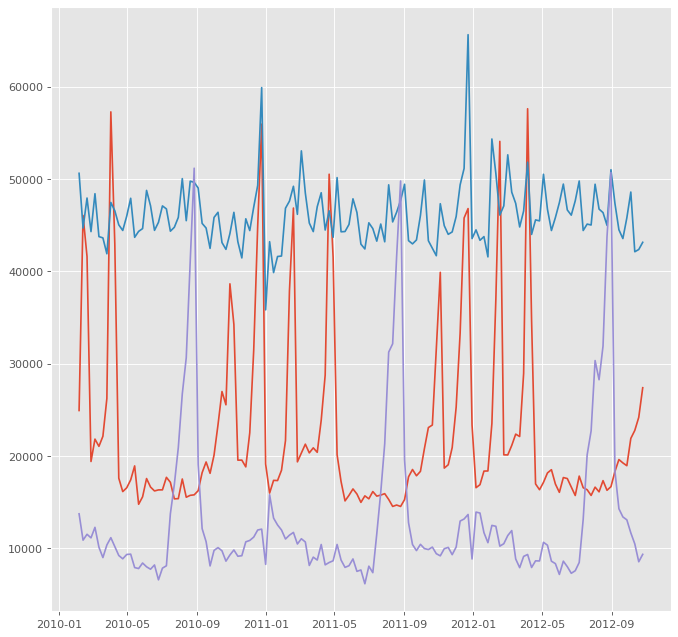

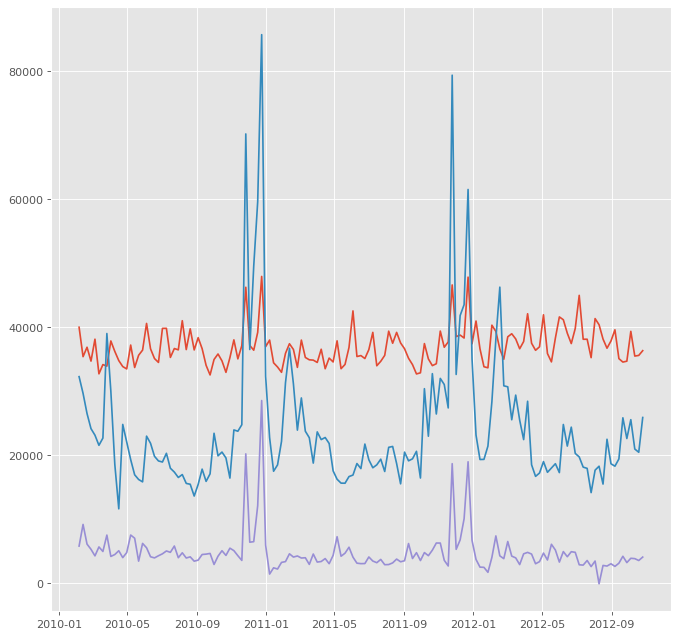

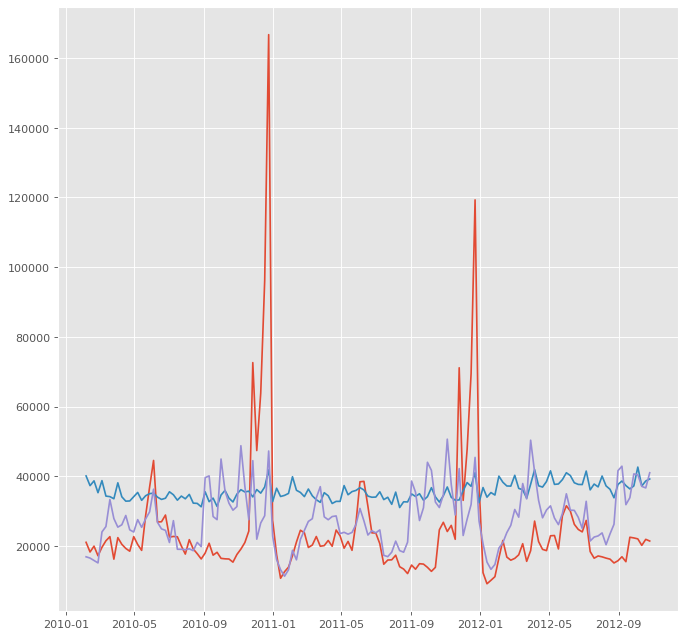

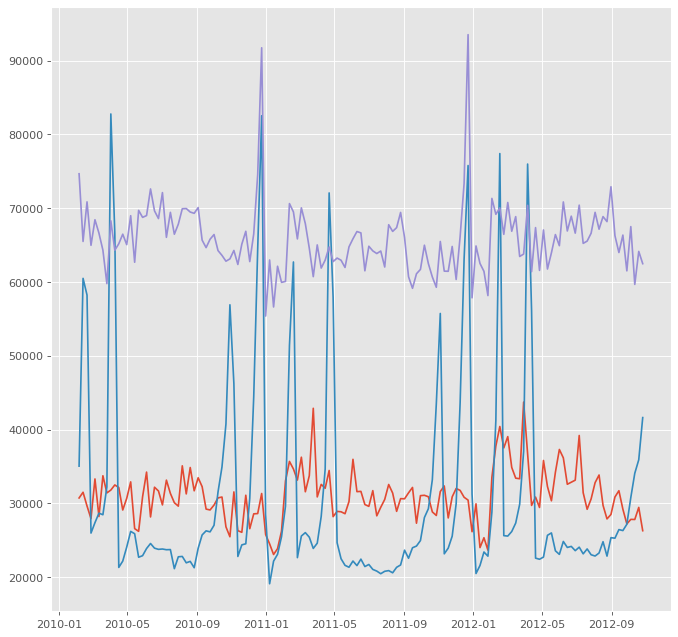

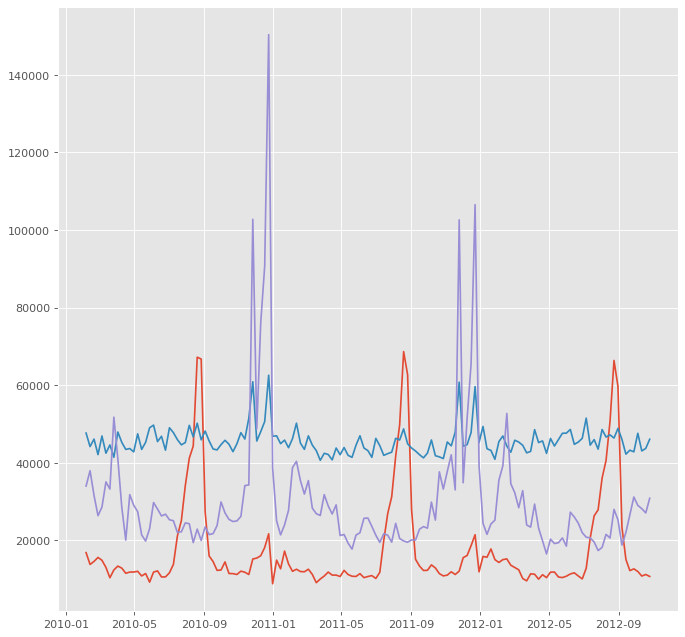

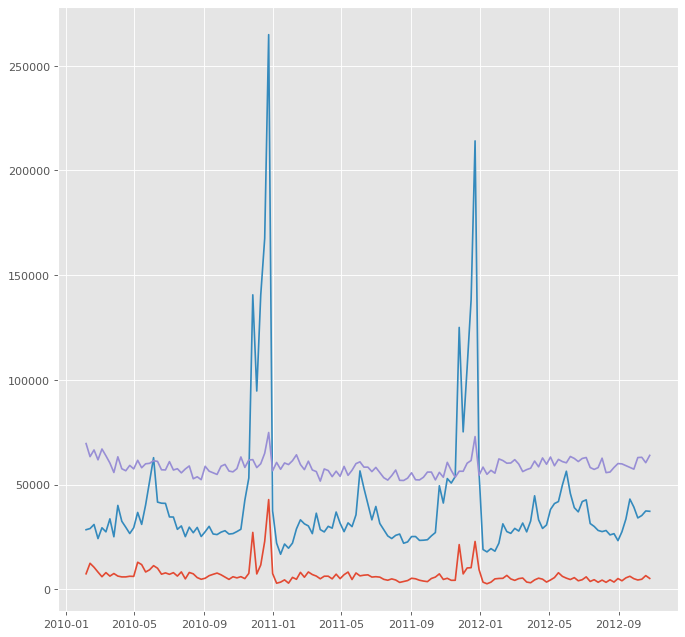

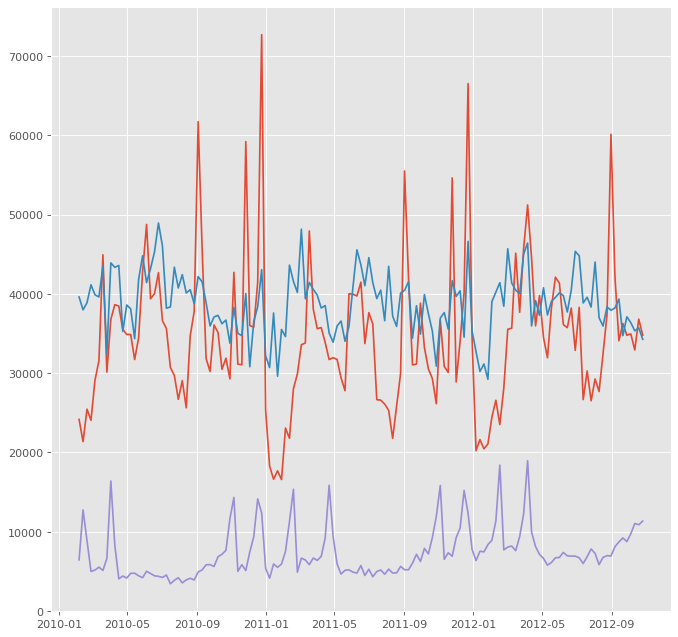

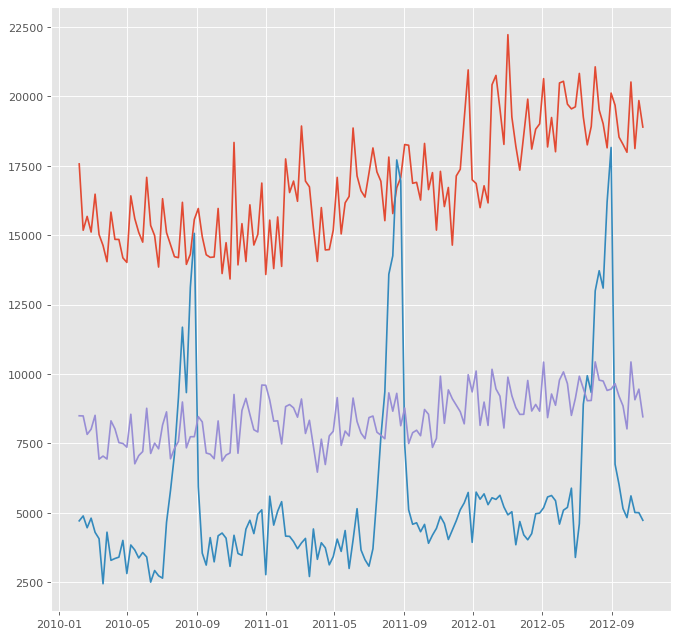

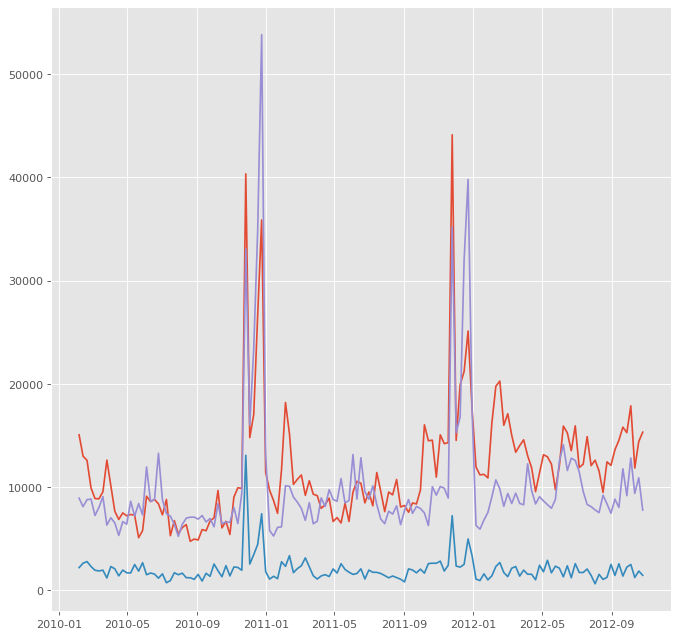

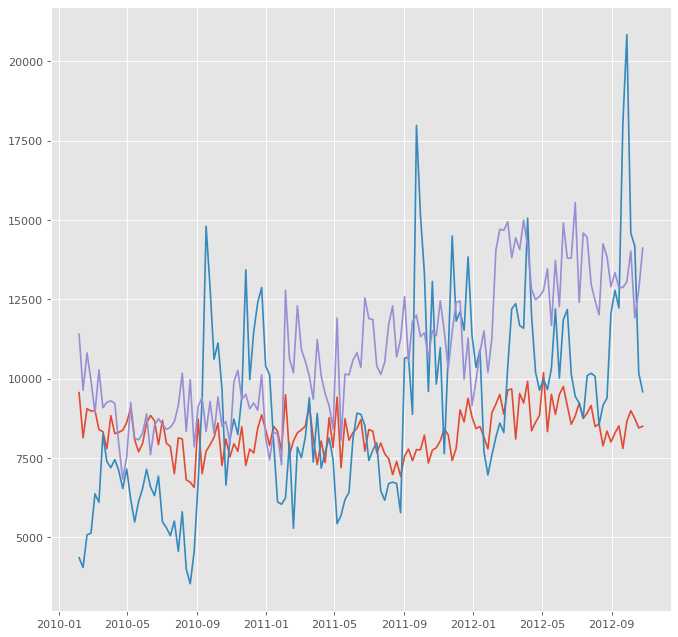

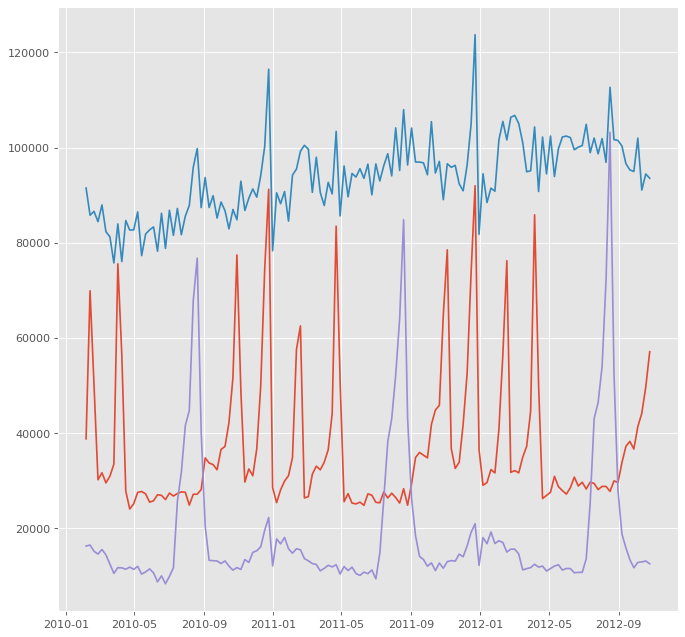

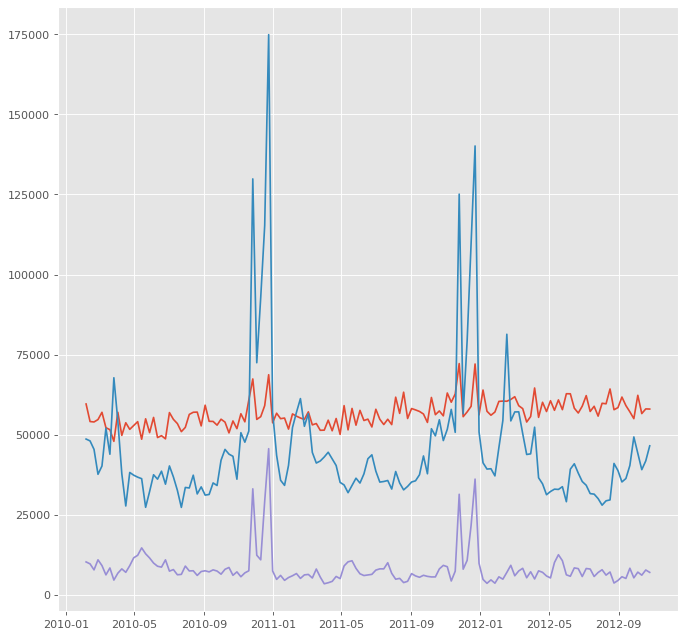

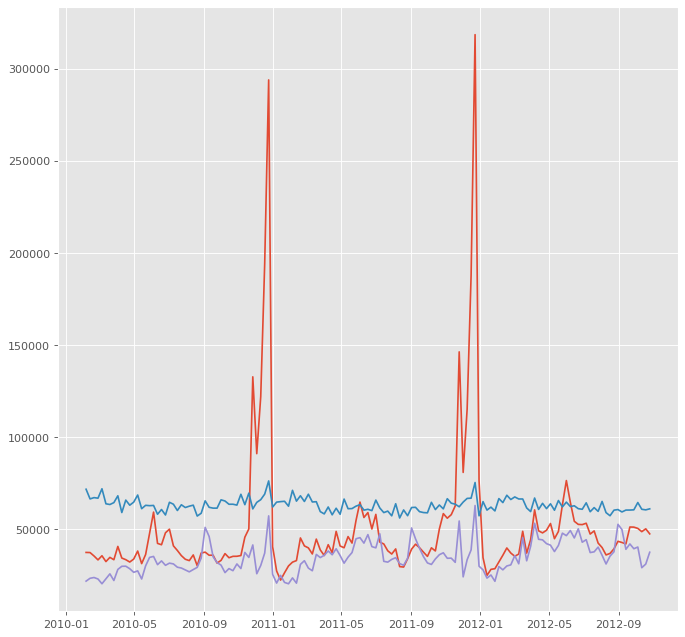

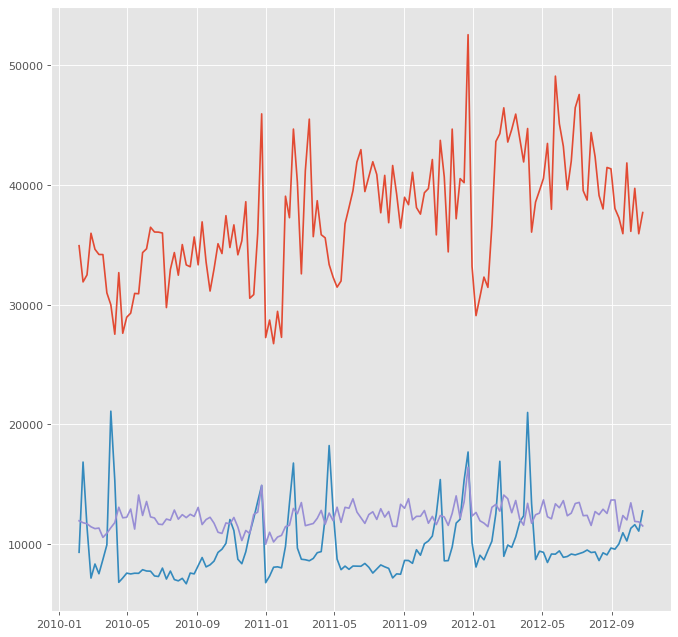

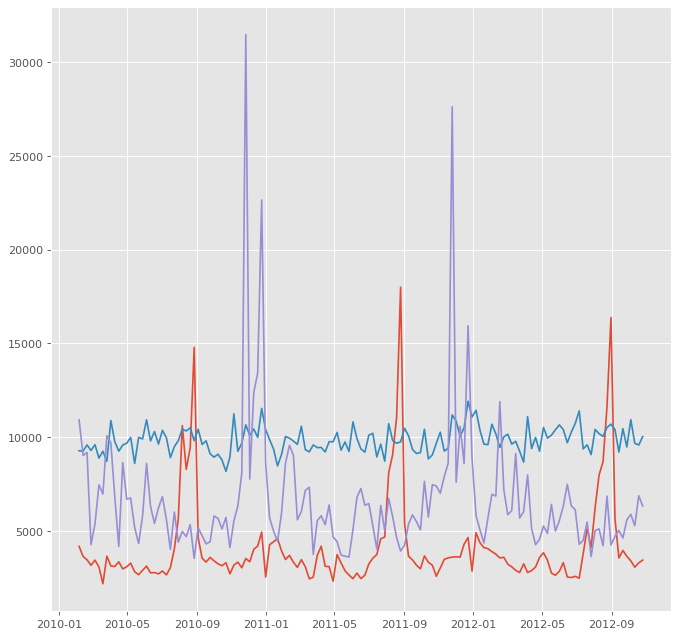

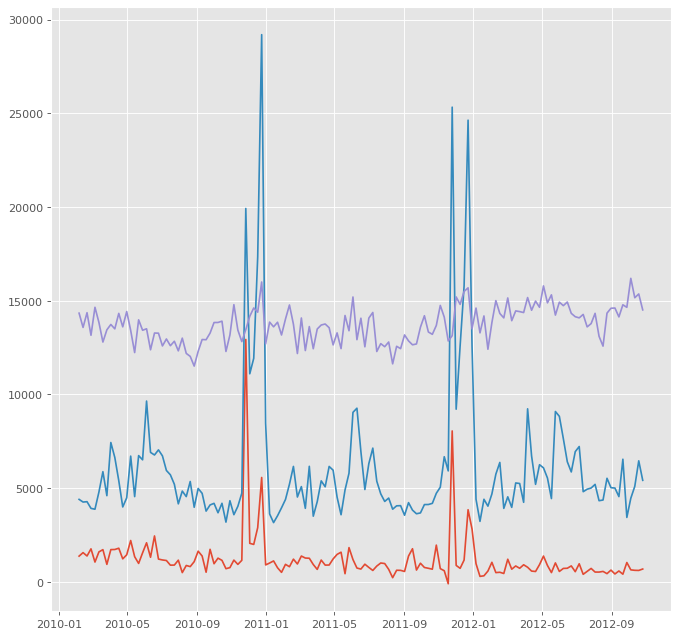

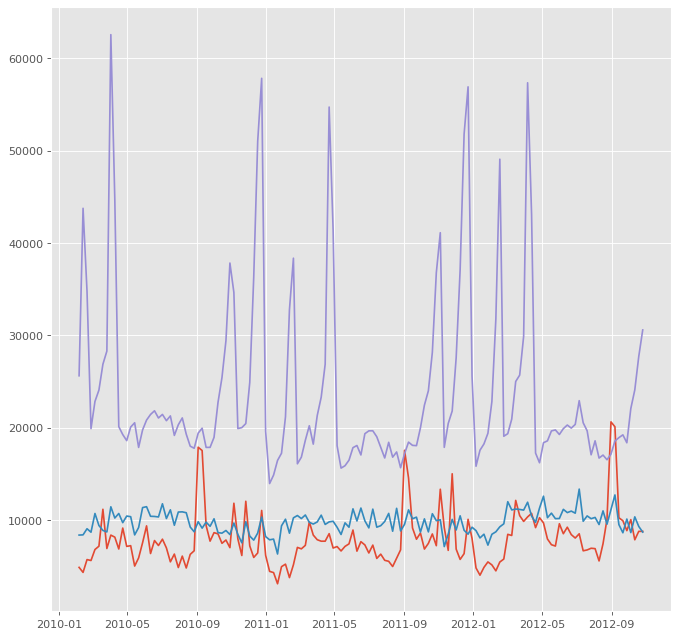

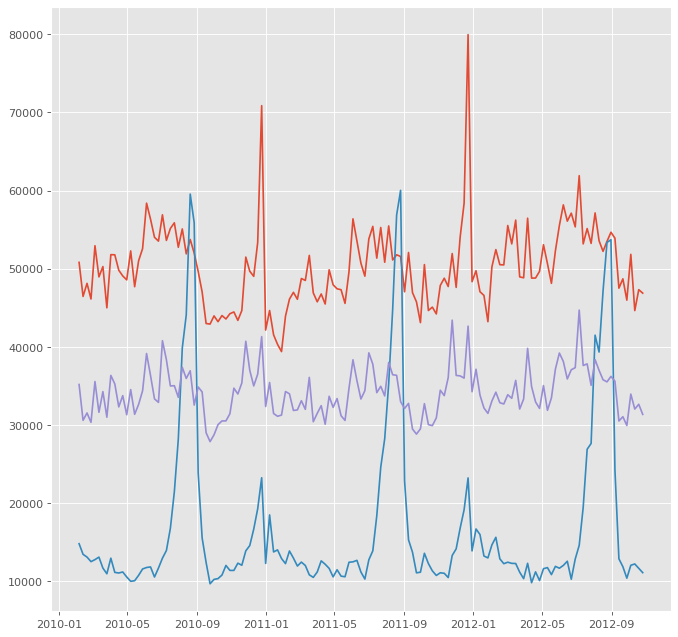

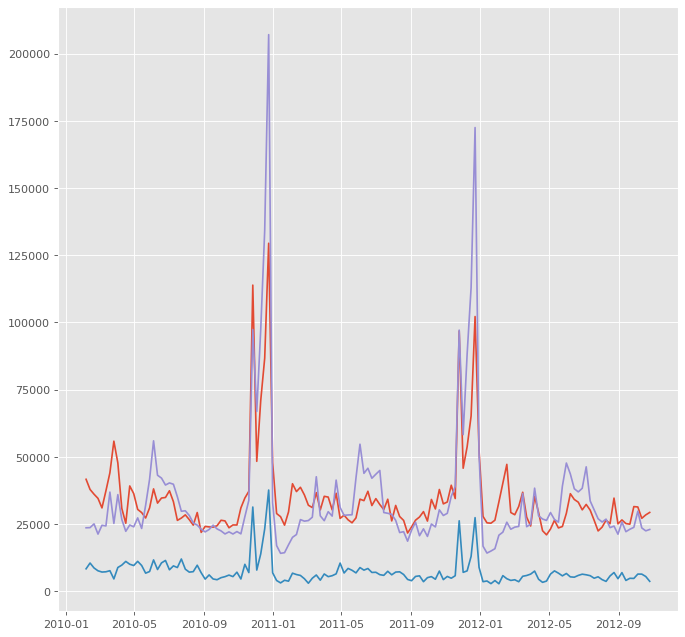

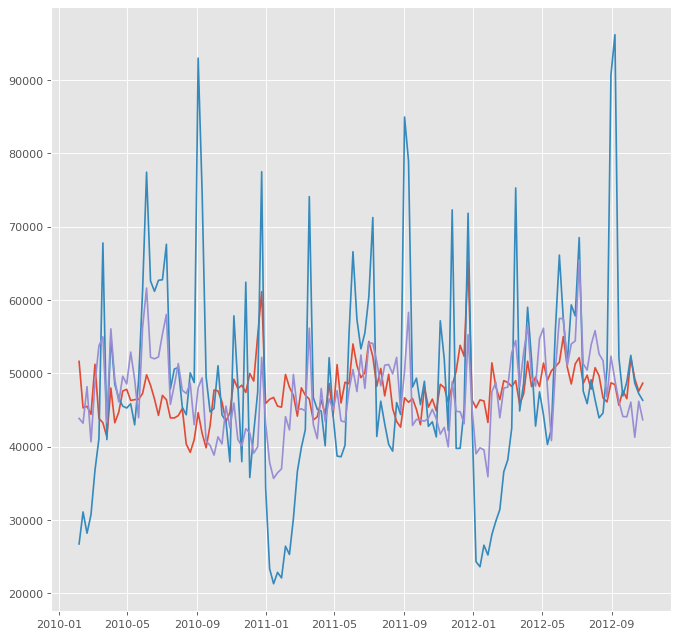

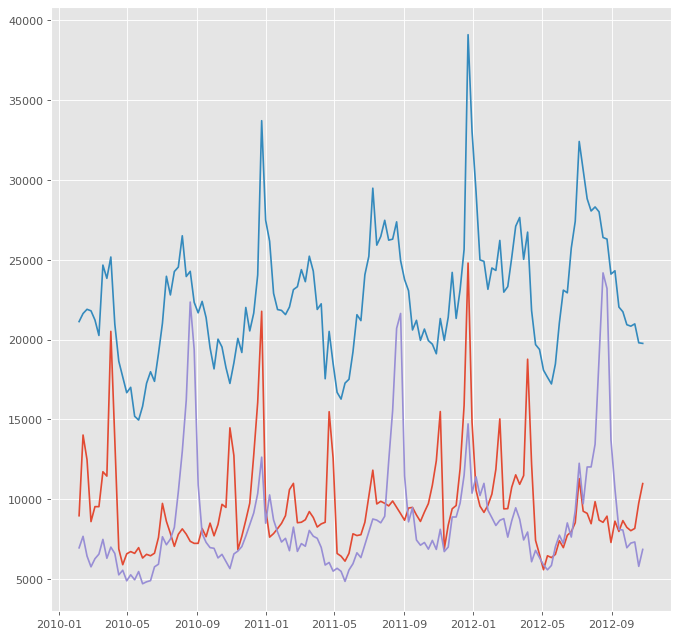

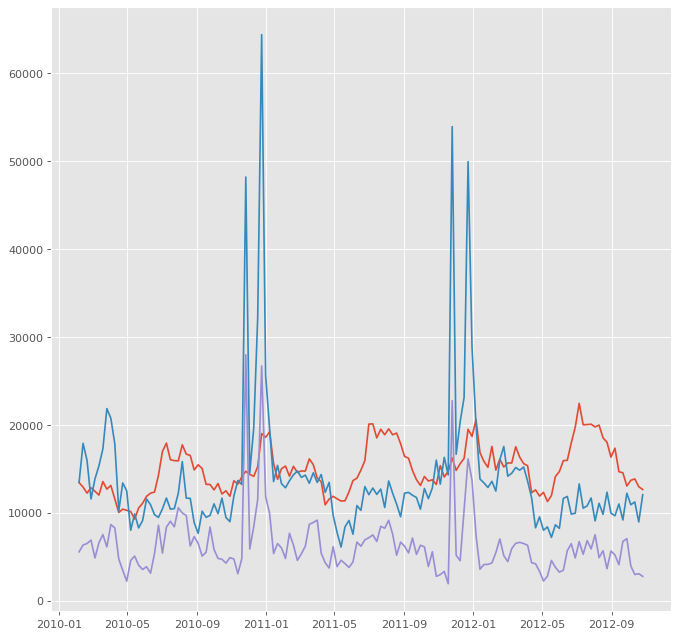

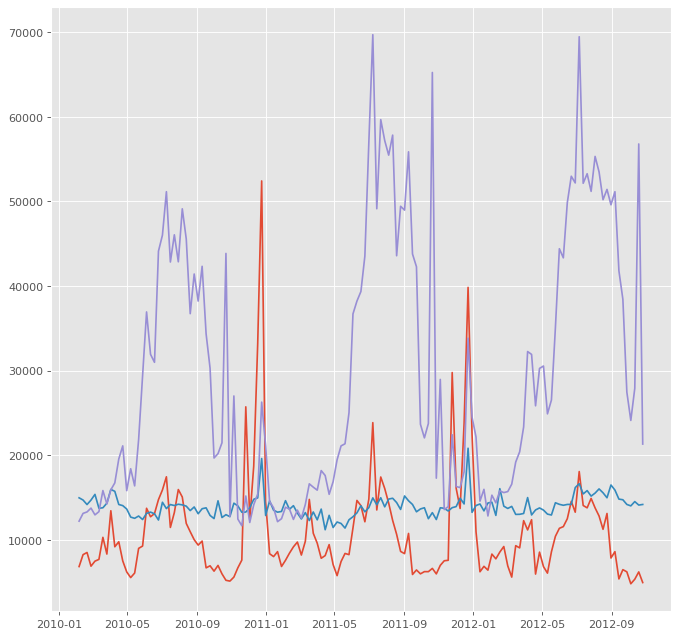

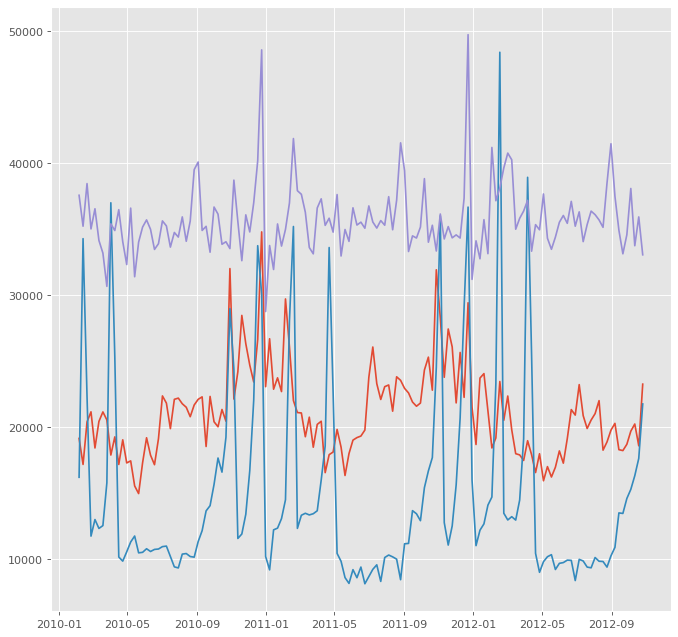

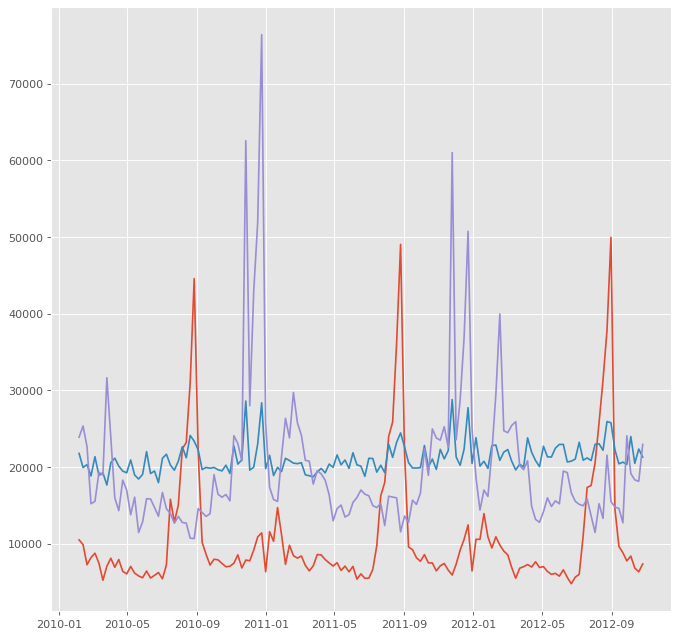

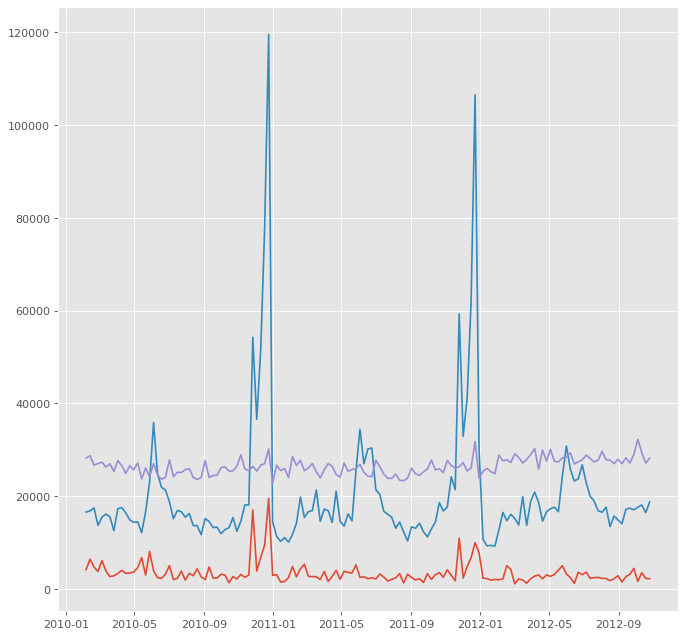

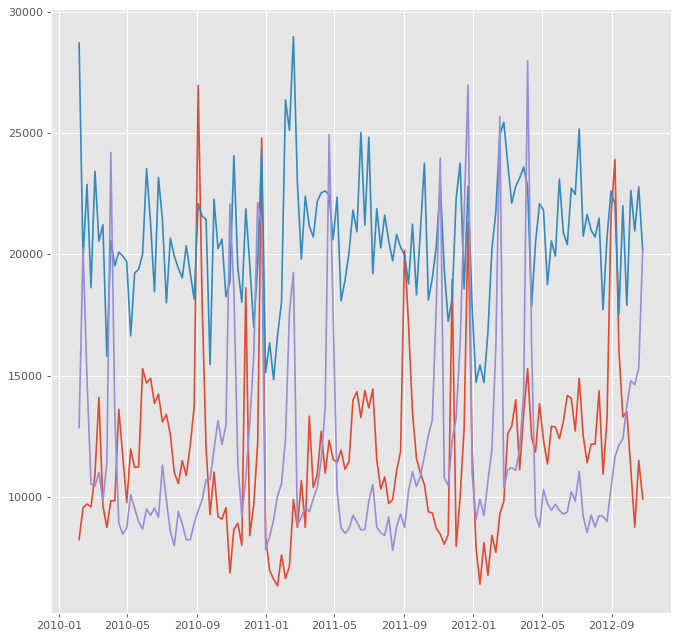

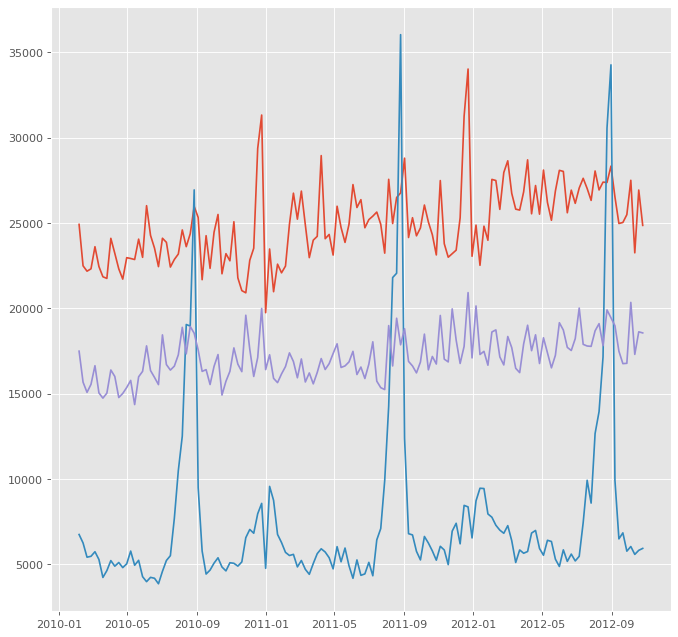

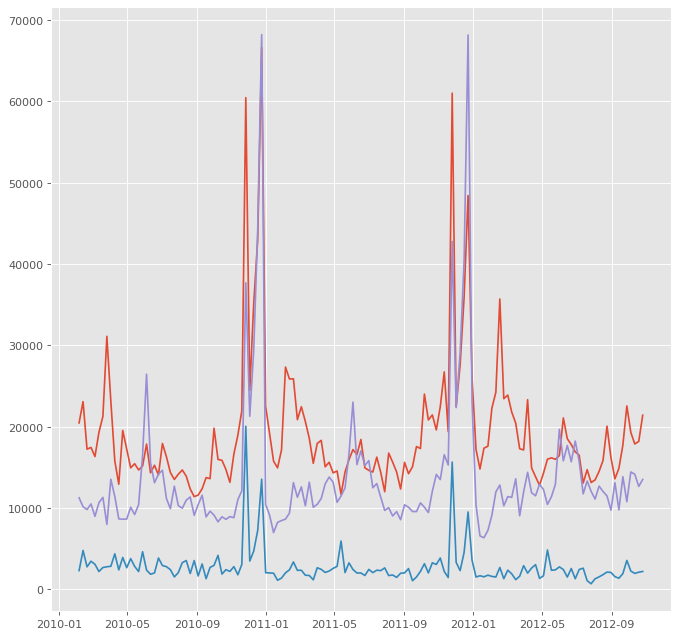

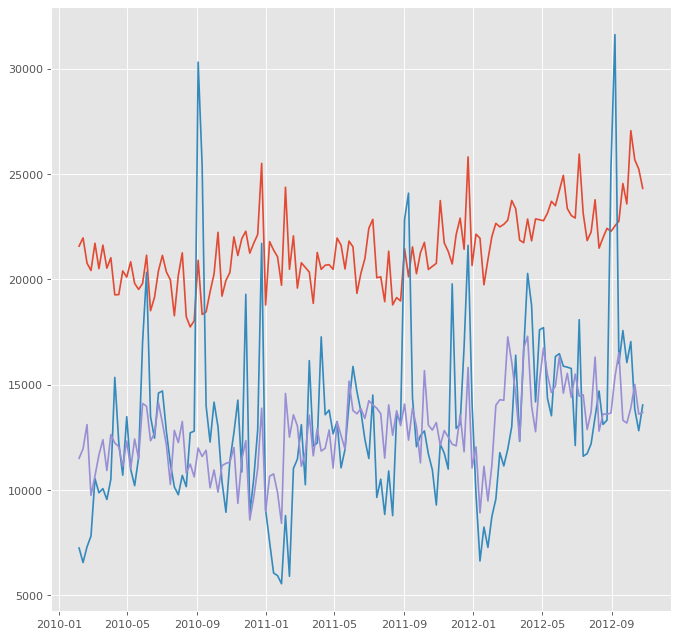

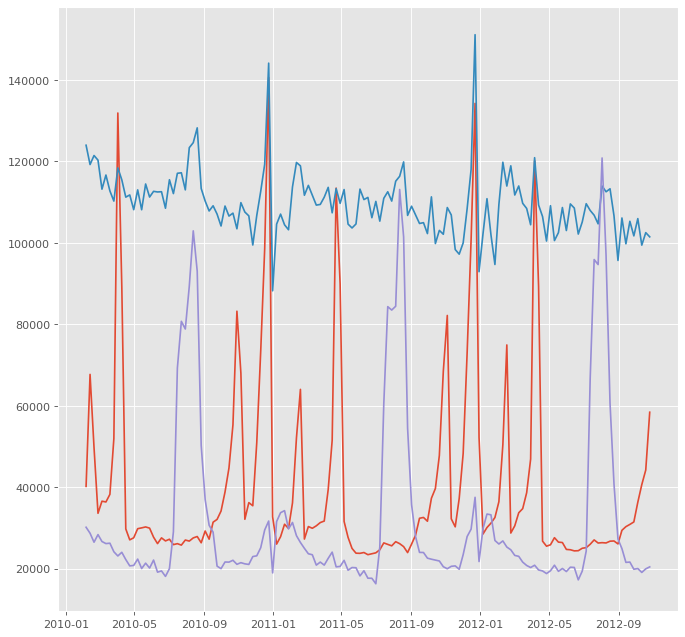

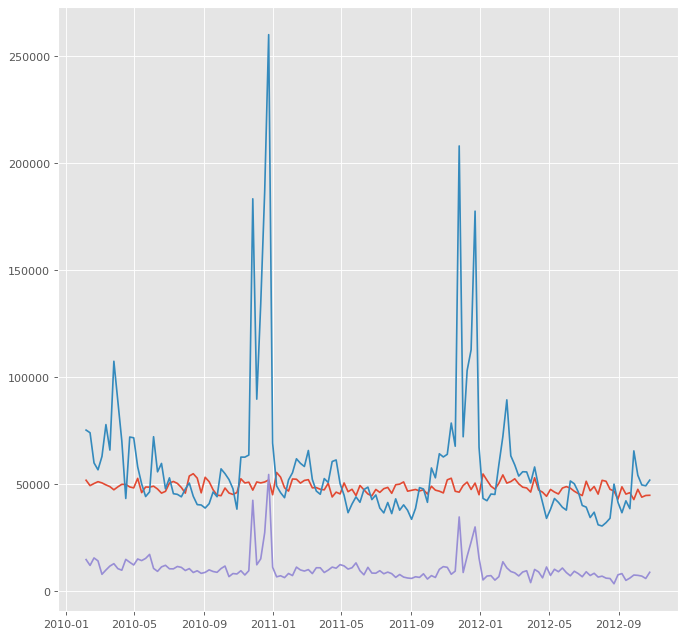

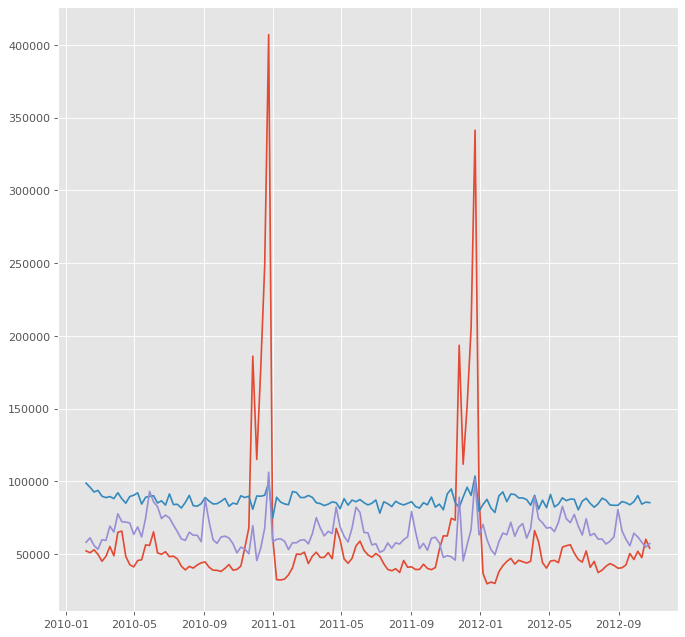

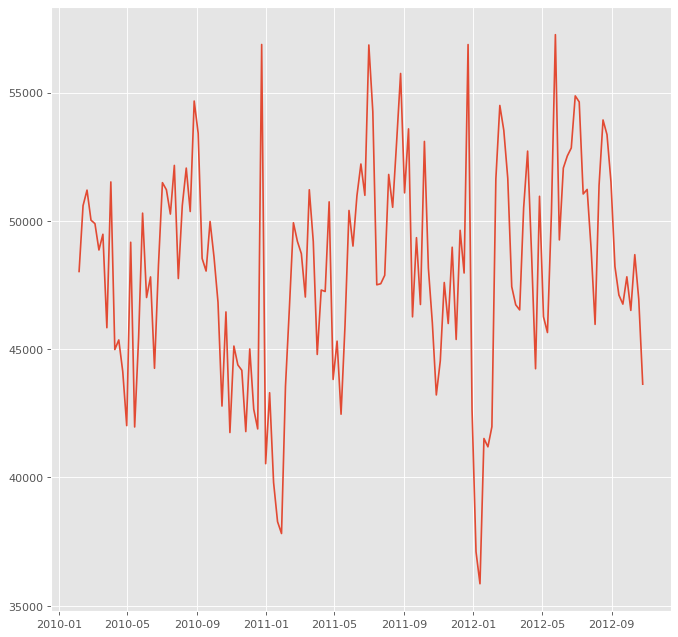

In [67]:
import warnings
warnings.filterwarnings("ignore")

figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
stores = sales_data['Store'].unique().tolist()[:10]
depts = sales_data['Dept'].unique().tolist()[:10]
counter = 0
for store in stores:
    for dept in depts:
        df = sales_data[(sales_data['Store'] == store) & (sales_data['Dept'] == dept)][['Date','Weekly_Sales']]
        if (counter > 0 and counter%3==0):
            import matplotlib.pyplot as plt
            from matplotlib.pyplot import figure
            figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
            plt.style.use('ggplot')
        plt.plot(df['Date'], df['Weekly_Sales'])
        name = 'Store'+str(store)+"Dept"+str(dept)+".png"
        counter = counter + 1

In [118]:
sales_store1_dept1_new = sales_store1_dept1.diff().dropna()
# sales_store1_dept1_new = sales_store1_dept1

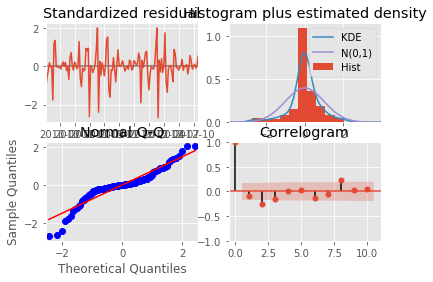

In [119]:
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 1-2
for p in range(1,3):
  # Loop over q values from 1-2
    for q in range(1,3):
        
        for P in range(1,3):
            
            for Q in range(1,3):

                # create and fit ARMA(p,q) model
                model = SARIMAX(sales_store1_dept1_new['Weekly_Sales'],
                                order=(p,1,q),
                                seasonal_order=(P,1,Q,17))

                results = model.fit()

                # Append order and results tuple
                order_aic_bic.append((p,q,P,Q,results.aic, results.bic))
        
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'q', 'P', 'Q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
best_param_df = pd.DataFrame(order_df.sort_values('AIC')).iloc[0:1,0:4]

model = SARIMAX(sales_store1_dept1_new['Weekly_Sales'],
                order=(int(best_param_df['p']),1,int(best_param_df['q'])),
                seasonal_order=(int(best_param_df['P']),1,int(best_param_df['Q']),7))

results = model.fit()

results.plot_diagnostics()

plt.show()

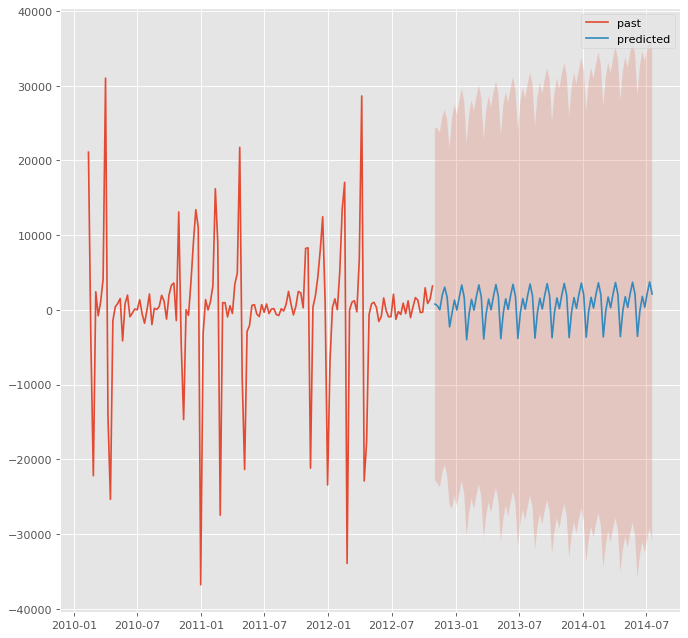

2127.398788143322
lower Weekly_Sales   -30886.748108
upper Weekly_Sales    35141.545684
Name: 2014-07-18 00:00:00, dtype: float64


In [120]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.style.use('ggplot')

# extracting the results:

# Create forecast object
forecast_object = results.get_forecast(steps=90)

# Extract prediction mean
mean = forecast_object.predicted_mean

# Extract the confidence intervals
conf_int = forecast_object.conf_int()

# Extract the forecast dates
dates = mean.index

# Plot past CO2 levels
plt.plot(sales_store1_dept1_new.index, sales_store1_dept1_new, label='past')

# Plot the prediction means as line
plt.plot(dates, mean, label='predicted')

# Shade between the confidence intervals
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2)

# Plot legend and show figure
plt.legend()

plt.show()
# PLotting it all over

# Print last predicted mean
print(mean.iloc[-1])

# Print last confidence interval
print(conf_int.iloc[-1])

### Prophet Prediction

In [35]:
from scipy import stats
import statsmodels.api as sm

from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

In [5]:
from fbprophet import Prophet

import logging
logging.getLogger().setLevel(logging.ERROR)

In [16]:
# sales_store1_dept1.reset_index(inplace = True)
df = sales_store1_dept1
df.columns = ['ds', 'y']
df.tail(n=3)

,ds,y
140,2012-10-12,22764.01
141,2012-10-19,24185.27
142,2012-10-26,27390.81


In [17]:
prediction_size = 30
train_df = df[:-prediction_size]
train_df.tail(n=3)

,ds,y
110,2012-03-16,22366.88
111,2012-03-23,22107.70
112,2012-03-30,28952.86


In [18]:
m = Prophet()
m.fit(train_df);

In [19]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

,ds
140,2012-04-27
141,2012-04-28
142,2012-04-29


In [20]:
forecast = m.predict(future)
forecast.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
140,2012-04-27,22821.786505,19087.841815,34170.133585,22821.786474,22821.786530,4263.063672,4263.063672,4263.063672,4263.063672,4263.063672,4263.063672,0.0,0.0,0.0,27084.850177
141,2012-04-28,22822.077592,18612.115995,33861.733192,22822.077559,22822.077620,3811.362432,3811.362432,3811.362432,3811.362432,3811.362432,3811.362432,0.0,0.0,0.0,26633.440024
142,2012-04-29,22822.368679,18388.233654,33524.497636,22822.368645,22822.368708,3336.856296,3336.856296,3336.856296,3336.856296,3336.856296,3336.856296,0.0,0.0,0.0,26159.224975


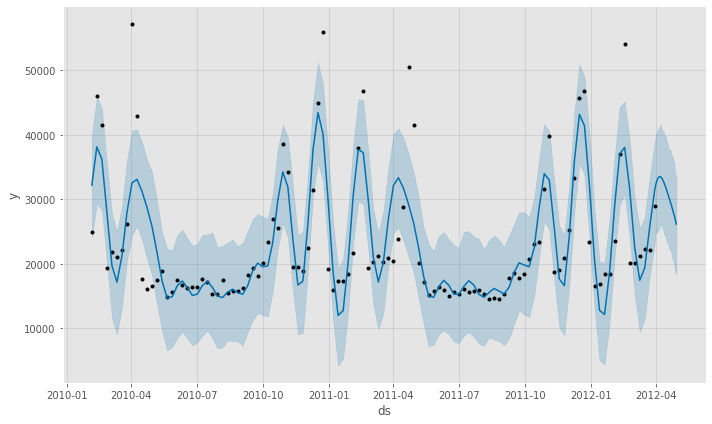

In [21]:
m.plot(forecast);


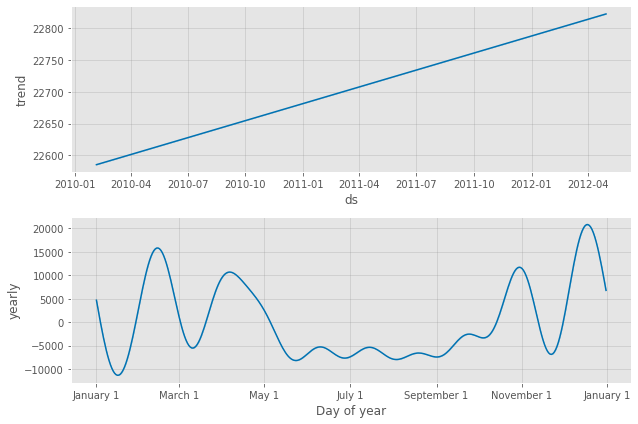

In [22]:
m.plot_components(forecast);


In [26]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [27]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.tail(n=3)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2012-04-27,27084.850177,19087.841815,34170.133585,16347.6
2012-04-28,26633.440024,18612.115995,33861.733192,NaN
2012-04-29,26159.224975,18388.233654,33524.497636,NaN


In [28]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [29]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 47.56308057903385
MAE 12532.412513769437


In [44]:
def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""
    
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="gray"))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="gray"),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='Posts'), title=title, showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df, prediction_size, 100, 'Weekly Revenue')

### Box Cox Transformation

In [31]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [32]:
train_df2 = train_df.copy().set_index('ds')


In [37]:
train_df2['y'], lambda_prophet = stats.boxcox(train_df2['y'])
train_df2.reset_index(inplace=True)

In [40]:
m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=prediction_size)
forecast2 = m2.predict(future2)

In [41]:
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast2[column] = inverse_boxcox(forecast2[column], lambda_prophet)

/home/sagnik/.local/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

invalid value encountered in log



In [42]:
cmp_df2 = make_comparison_dataframe(df, forecast2)
for err_name, err_value in calculate_forecast_errors(cmp_df2, prediction_size).items():
    print(err_name, err_value)

MAPE 91.13250146704861
MAE 20687.73105909388


In [43]:
show_forecast(cmp_df, prediction_size, 100, 'No transformations')
show_forecast(cmp_df2, prediction_size, 100, 'Box–Cox transformation')